In [ ]:
!pip install datasets
#!pip install torch
!apt-get install -y libsox-dev

In [ ]:
# Imports

from __future__ import annotations
import random, math, sys, time
from pathlib import Path
import os, json, pickle
import torch, torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from tqdm.notebook import tqdm   # Progress‑bar

# --------------------------------------------------------
# Waveform → log‑Mel / MFCC  (with augments)
# --------------------------------------------------------
class MyPipeline(nn.Module):
    def __init__(
        self,
        feature_type: str = "mel",
        sample_rate: int = 16_000,
        n_fft: int = 2048,
        n_mel: int = 128,
        hop_length: int = 128,
        n_mfcc: int = 40,
        stretch_range: tuple[float,float] = (1.0,1.0),
        shift_ms: int = 0,
        noise_std_range: tuple[float,float] = (0.0,0.0),
        normalize: bool | tuple[float,float] = False,
        apply_aug: bool = True,
    ) -> None:
        super().__init__()
        self.feature_type = feature_type.lower(); assert self.feature_type in {"mel","mfcc"}
        self.sample_rate, self.hop_length = sample_rate, hop_length
        self.normalize, self.apply_aug = normalize, apply_aug
        self.mel_spec = T.MelSpectrogram(sample_rate, n_fft, hop_length, n_mel, power=2)
        self.mfcc_transform = T.MFCC(sample_rate, n_mfcc, melkwargs=dict(n_fft=n_fft, hop_length=hop_length, n_mels=n_mel)) if self.feature_type=="mfcc" else None
        self.to_db = T.AmplitudeToDB(stype="power")
        self.stretch_range, self.shift_samples, self.noise_std_range = stretch_range, int(shift_ms*sample_rate/1000), noise_std_range

    def _time_shift(self, wav:torch.Tensor):
        if self.shift_samples==0: return wav
        shift = int(torch.randint(-self.shift_samples,self.shift_samples+1,()).item())
        if shift==0: return wav
        if shift>0:
            return F.pad(wav,(shift,0),value=0.0)[..., :-shift]
        return F.pad(wav,(0,-shift),value=0.0)[..., -shift:]

    def forward(self, waveform: torch.Tensor):
        if waveform.dim()==1: waveform = waveform.unsqueeze(0)
        if self.apply_aug:
            if self.stretch_range!=(1.0,1.0):
                factor=float(torch.empty((),dtype=torch.float32).uniform_(*self.stretch_range))
                if abs(factor-1.0)>1e-4:
                    waveform,_=torchaudio.sox_effects.apply_effects_tensor(waveform,self.sample_rate,[["tempo",f"{factor}"]])
            waveform=self._time_shift(waveform)
            if self.noise_std_range[1]>0:
                sigma=float(torch.empty((),dtype=torch.float32).uniform_(*self.noise_std_range))
                if sigma>0: waveform=waveform+torch.randn_like(waveform)*sigma
        if self.feature_type=="mfcc":
            features=self.mfcc_transform(waveform)
        else:
            mel=self.mel_spec(waveform).clamp(min=1e-10)
            features=self.to_db(mel)
        if isinstance(self.normalize,tuple):
            mean,std=self.normalize; features=(features-mean)/std
        elif self.normalize is True:
            features=(features-features.mean())/(features.std()+1e-8)
        return features

# --------------------------------------------------------
# HuggingFace dataset loader
# --------------------------------------------------------
class SpeechCommandsDataset(Dataset):
    def __init__(self, hf_split, pipeline:MyPipeline|None=None, waveform_len:int=16_000):
        self.hf_split,self.pipeline=hf_split,pipeline
        self.max_frames=((waveform_len-pipeline.mel_spec.n_fft)//pipeline.mel_spec.hop_length+1) if pipeline else None
    def __len__(self): return len(self.hf_split)
    def __getitem__(self,idx):
        s=self.hf_split[idx]; wav=torch.from_numpy(s["audio"]["array"]).float(); lab=s["label"]
        if self.pipeline is None: return wav,lab
        feats=self.pipeline(wav); frames=feats.size(-1)
        if frames<self.max_frames:
            feats=F.pad(feats,(0,self.max_frames-frames),value=-80.0)
        elif frames>self.max_frames:
            feats=feats[...,:self.max_frames]
        return feats,lab

# --------------------------------------------------------
# Simple CNN Example
# --------------------------------------------------------
class KeywordCNN(nn.Module):
    def __init__(self,n_mels:int,n_frames:int,n_classes:int):
        super().__init__()
        self.features=nn.Sequential(
            nn.Conv2d(1,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1),nn.BatchNorm2d(64),nn.ReLU(),nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1),nn.BatchNorm2d(128),nn.ReLU(),nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier=nn.Linear(256,n_classes)

    def forward(self,x):
        x = self.features(x)
        x = self.gap(x).flatten(1)
        return self.classifier(x)

# --------------------------------------------------------
# Train / eval helpers with tqdm (progress bar)
# --------------------------------------------------------
@torch.no_grad()
def evaluate(model,loader,device):
    model.eval(); tot=correct=loss_sum=0.0
    for xb,yb in loader:
        xb,yb=xb.to(device),yb.to(device)
        logits=model(xb); loss=F.cross_entropy(logits,yb)
        loss_sum+=loss.item()*xb.size(0); pred=logits.argmax(1)
        correct+=(pred==yb).sum().item(); tot+=xb.size(0)
    return loss_sum/tot,100.0*correct/tot



In [ ]:

# Main for training
if __name__ == "__main__":
    ds = load_dataset("google/speech_commands", "v0.02")

    # -----------------  PIPELINES  -----------------
    pipe_train = MyPipeline(feature_type="mel",
                            apply_aug=True,
                            stretch_range=(0.90, 1.1),
                            shift_ms=100,
                            noise_std_range=(0, 0.001),
                            normalize=False)

    pipe_eval  = MyPipeline(feature_type="mel",   # No augment at val/test
                            apply_aug=False,
                            normalize=False)

    train_set = SpeechCommandsDataset(ds["train"],      pipe_train)
    val_set   = SpeechCommandsDataset(ds["validation"], pipe_eval)
    test_set  = SpeechCommandsDataset(ds["test"],       pipe_eval)

    train_loader = DataLoader(train_set, 64, shuffle=True,  num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_set,   64, shuffle=False, num_workers=4, pin_memory=True)

    n_classes = len(ds["train"].features["label"].names)
    device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model     = KeywordCNN(pipe_train.mel_spec.n_mels,
                           train_set.max_frames,
                           n_classes).to(device)

    opt   = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)

    best_val_acc = 0.0                      # Track best for checkpoint
    epochs = 15
    for ep in range(1, epochs + 1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}")
        running_loss = correct = total = 0
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss   = F.cross_entropy(logits, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            pred = logits.argmax(1)
            correct += (pred == yb).sum().item()
            total   += xb.size(0)
            running_loss += loss.item() * xb.size(0)
            pbar.set_postfix(loss=f"{running_loss/total:.4f}",
                             acc=f"{100*correct/total:.1f}%")

        sched.step()
        v_loss, v_acc = evaluate(model, val_loader, device)
        print(f"\nEpoch {ep} ▸ val loss {v_loss:.4f} – val acc {v_acc:.2f}%\n")

        # Save the best checkpoint so far
        if v_acc > best_val_acc:
            best_val_acc = v_acc
            torch.save(model.state_dict(), "/content/best_kws.pt")
            print(f"  ✔︎  New best – saved interim model (val {v_acc:.2f}%)\n")


    # -------------------------------------------------------
    #               SAVE TO GOOGLE DRIVE
    # -------------------------------------------------------
    from google.colab import drive
    drive.mount("/content/drive")

    CKPT_DIR = "/content/drive/MyDrive/kws_models"
    os.makedirs(CKPT_DIR, exist_ok=True)
    ckpt_path = f"{CKPT_DIR}/keyword_cnn_final.pt"
    torch.save(model.state_dict(), ckpt_path)
    print("✅ Model weights saved to:", ckpt_path, "\n")

    # Save front-end config so you can rebuild pipeline later
    json.dump({"feature_type": "mel",
               "sample_rate": 16000,
               "n_fft": 2048,
               "n_mel": 128,
               "hop_length": 128,
               "normalize": False},
              open(f"{CKPT_DIR}/mel_config.json", "w"), indent=2)
    # -------------------------------------------------------

    # final test-set score
    t_loss, t_acc = evaluate(model, DataLoader(test_set, 64), device)
    print(f"Test accuracy {t_acc:.2f}% – loss {t_loss:.4f}")


In [ ]:
# Load dataset and set up pipeline

dataset_dict = load_dataset("google/speech_commands", "v0.02")
pipeline = MyPipeline(
    feature_type="mel",
    apply_aug=True,
    stretch_range=(0.95, 1.05),
    shift_ms=70,              # ±70 ms random shift
    noise_std_range=(0.0, 0.01),
    normalize=False,
)

train_dataset = SpeechCommandsDataset(dataset_dict["train"], pipeline=pipeline)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

Batch tensor shape: torch.Size([16, 1, 128, 110]) (batch, channels, mel-bins | mfcc, frames)


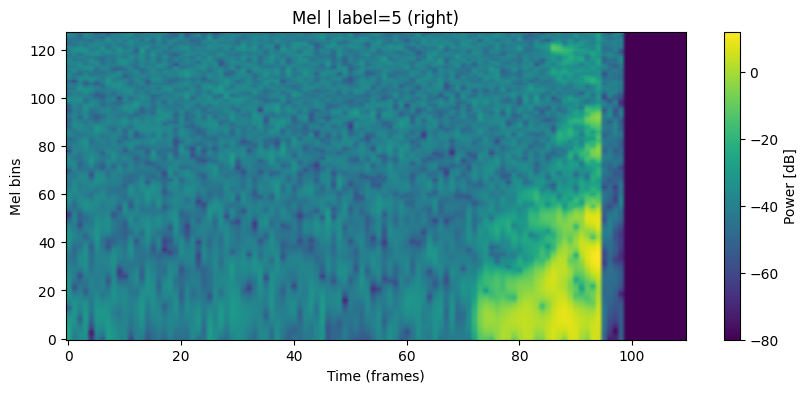

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Pull the authoritative label names
label_map = dataset_dict["train"].features["label"].names

# Fetch one batch
for features, labels in train_loader:
    print(
        "Batch tensor shape:",
        features.shape,
        "(batch, channels, mel-bins | mfcc, frames)",
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(
        features[0, 0].numpy(),
        aspect="auto",
        origin="lower",
        cmap="viridis",
    )
    fig.colorbar(im, ax=ax, label="Power [dB]" if pipeline.feature_type == "mel" else "Energy")
    ax.set(
        xlabel="Time (frames)",
        ylabel="Mel bins" if pipeline.feature_type == "mel" else "MFCC coeff.",
        title=f'{("Mel" if pipeline.feature_type=="mel" else "MFCC")} '
              f'| label={labels[0].item()} ({label_map[labels[0]]})',
    )
    plt.show()
    break  # only the first batch

# Listen to a raw waveform
first = dataset_dict["train"][0]
display(Audio(first["audio"]["array"], rate=16000))


In [ ]:
import torch
from IPython.display import Audio, display

def augment_once(pipeline: MyPipeline, wav_np: np.ndarray, seed=None):
    """
    Apply the *waveform-level* augmentations of `pipeline`
    and return an augmented NumPy signal.

    • Uses the same random ranges as in training.
    • Ignores the spectrogram step and normalisation.
    """
    if seed is not None:
        torch.manual_seed(seed)          # reproducible demo

    wav = torch.from_numpy(wav_np).float()          # 1-D tensor
    if wav.dim() == 1:
        wav = wav.unsqueeze(0)                     # [1, time]

    # -----   1) time-stretch   --------------------------------
    if pipeline.apply_aug and (
        pipeline.stretch_range[0] != 1.0
        or pipeline.stretch_range[1] != 1.0
    ):
        factor = torch.empty(()).uniform_(*pipeline.stretch_range).item()
        if factor != 1.0:
            wav, _ = torchaudio.sox_effects.apply_effects_tensor(
                wav, pipeline.sample_rate, [["tempo", f"{factor}"]]
            )

    # -----   2) time-shift   ----------------------------------
    if pipeline.apply_aug and pipeline.shift_samples > 0:
        wav = pipeline._time_shift(wav)

    # -----   3) additive noise   ------------------------------
    if (
        pipeline.apply_aug
        and pipeline.noise_std_range[1] > 0.0
    ):
        sigma = torch.empty(()).uniform_(*pipeline.noise_std_range).item()
        if sigma > 0.0:
            wav = wav + torch.randn_like(wav) * sigma

    return wav.squeeze(0).numpy()        # back to 1-D NumPy



# pick an example
raw_np = dataset_dict["train"][0]["audio"]["array"]

# hear the original
display(Audio(raw_np, rate=16000))

# hear ONE random augmentation draw
aug_np = augment_once(pipeline, raw_np)    # same pipeline you use in training
display(Audio(aug_np, rate=16000))

# …draw a few more if you like
for _ in range(3):
    display(Audio(augment_once(pipeline, raw_np), rate=16000))